steganography_system.py

# Steganography System

Comprehensive Steganographic System for Defense Applications
Innovation Project for Secure Information Hiding

Team: The Encryptors
<br>Hackathon: PYdroid By Android club
<br>Date: 26-7-25

Purpose: This script demonstrates a comprehensive steganographic system
designed for secure information hiding within digital media, with a focus
on applications relevant to defense industries (e.g., secure communication,
covert data transmission, digital watermarking for intellectual property).

Disclaimer: This project is for educational and research purposes only,
demonstrating advanced concepts in cryptography and steganography.
Responsible and ethical use is paramount.

In [1]:
# --- SECTION 1: Setup and Library Imports ---
import os
import random
import numpy as np
from PIL import Image # Pillow library for image processing
from scipy.io import wavfile # For reading/writing WAV audio files
import json
import base64
from pathlib import Path # For robust file path handling
import matplotlib.pyplot as plt # For visualizing images
import cv2 # OpenCV for video processing

In [2]:
# Cryptography specific imports
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding, hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa, padding as rsa_padding
# import Crypto.Cipher.AES # pycryptodome - Imported as requested, but 'cryptography' is used for core AES.

In [3]:
# New requested imports
import librosa # For audio analysis (imported as requested, not actively used in current stego logic)
from pydub import AudioSegment # For audio file conversion (e.g., MP3 to WAV)
import soundfile as sf # For reading/writing sound files (imported as requested, not actively used in current stego logic)
#import moviepy.editor as mp # For video editing (imported as requested, not actively used in current stego logic)
import tkinter as tk # For desktop GUI (imported as requested, GUI not implemented in CLI script)
# import streamlit as st # For web GUI (imported as requested, GUI not implemented in CLI script)
# Streamlit typically requires running 'streamlit run your_script.py', so it's commented out for direct execution.
# If you want to use Streamlit, this line should be uncommented and the main loop changed.

C:\Users\vedan\AppData\Roaming\Python\Python312\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
# Optional: For audio playback in environments like Jupyter/Colab
try:
    from IPython.display import Audio, display
    IPYTHON_AUDIO_AVAILABLE = True
except ImportError:
    IPYTHON_AUDIO_AVAILABLE = False

In [5]:
print("All necessary libraries imported.")

All necessary libraries imported.


--- SECTION 2: Helper Functions (General Data Conversion) ---

In [6]:
def bytes_to_bits(data_bytes: bytes) -> list[int]:
    """Converts a bytes object to a list of integer bits (0s and 1s)."""
    return [bit for byte in data_bytes for bit in [(byte >> i) & 1 for i in range(7, -1, -1)]]

In [7]:
def bits_to_bytes(bit_list: list[int]) -> bytes:
    """Converts a list of integer bits (0s and 1s) back to a bytes object."""
    # Ensure bit_list length is a multiple of 8, pad with zeros if necessary
    if len(bit_list) % 8 != 0:
        bit_list += [0] * (8 - (len(bit_list) % 8))

    byte_array = bytearray()
    for i in range(0, len(bit_list), 8):
        byte = 0
        for j in range(8):
            byte = (byte << 1) | bit_list[i + j]
        byte_array.append(byte)
    return bytes(byte_array)

In [8]:
print("General data conversion helper functions defined.")

General data conversion helper functions defined.


--- SECTION 3: Helper Functions (Audio Specific) ---

In [9]:
def read_wav_file(file_path: str) -> tuple[int, np.ndarray, int]:
    """
    Reads a WAV file.
    Args:
        file_path (str): Path to the WAV file.
    Returns:
        tuple: (rate (sample rate), data (numpy array of samples), n_channels (number of channels))
    Raises:
        FileNotFoundError: If the audio file does not exist.
    """
    if not Path(file_path).exists():
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    # Use scipy.io.wavfile as it's already integrated and works well for WAV LSB
    rate, data = wavfile.read(file_path) 
    
    # Ensure data is a 2D array for consistent processing (even for mono)
    if data.ndim == 1:
        data = data.reshape(-1, 1) # Reshape mono to (num_samples, 1)
        n_channels = 1
    else:
        n_channels = data.shape[1] # For stereo (num_samples, 2)
        
    return rate, data, n_channels

In [10]:
def write_wav_file(file_path: str, rate: int, data: np.ndarray):
    """
    Writes audio data to a WAV file.
    Args:
        file_path (str): Path to save the WAV file.
        rate (int): Sample rate of the audio.
        data (numpy.ndarray): Audio sample data.
    """
    wavfile.write(file_path, rate, data)

In [11]:
def get_audio_capacity_bits(audio_data: np.ndarray) -> int:
    """
    Calculates the maximum number of bits that can be hidden in audio data.
    Assumes 1 LSB per sample across all channels.
    Args:
        audio_data (numpy.ndarray): The audio sample data.
    Returns:
        int: Maximum number of bits that can be embedded.
    """
    return audio_data.size # Total number of samples (across all channels)

In [12]:
def embed_bits_in_audio(audio_data: np.ndarray, bits_to_embed: list[int]) -> np.ndarray:
    """
    Embeds a list of bits into the LSB of audio samples.
    Args:
        audio_data (numpy.ndarray): The original audio sample data.
        bits_to_embed (list): A list of 0s and 1s representing the secret data.
    Returns:
        numpy.ndarray: The stego audio data with bits embedded.
    Raises:
        ValueError: If too much data is provided to embed.
    """
    if len(bits_to_embed) > audio_data.size:
        raise ValueError(f"Too much data to embed! Audio capacity: {audio_data.size} bits. Data to embed: {len(bits_to_embed)} bits.")

    stego_audio_data = audio_data.copy()
    flat_stego_data = stego_audio_data.flatten()

    for i, bit in enumerate(bits_to_embed):
        # Clear the LSB (set to 0) and then set it to the secret bit
        # Use 0xFE (11111110) to mask out the LSB without causing negative values for uint8
        flat_stego_data[i] = (flat_stego_data[i] & 0xFE) | bit
        
    return flat_stego_data.reshape(audio_data.shape)

In [13]:
def extract_bits_from_audio(audio_data: np.ndarray, num_bits_to_extract: int, offset: int=0) -> list[int]:
    """
    Extracts a specified number of bits from the LSB of audio samples, with an offset.
    Args:
        audio_data (numpy.ndarray): The stego audio sample data.
        num_bits_to_extract (int): The number of bits to extract.
        offset (int): The starting sample index to extract from.
    Returns:
        list: A list of extracted bits (0s and 1s).
    """
    extracted_bits = []
    flat_audio_data = audio_data.flatten()

    for i in range(num_bits_to_extract):
        current_index = offset + i
        if current_index >= flat_audio_data.size:
            print(f"Warning: Attempting to extract more bits ({num_bits_to_extract}) than available samples from offset ({flat_audio_data.size - offset}). Stopping early.")
            break
        extracted_bits.append(flat_audio_data[current_index] & 1) # Get the LSB
    return extracted_bits

In [14]:
print("Audio-specific helper functions defined.")

Audio-specific helper functions defined.


--- SECTION 3.5: Helper Functions (Video Specific) ---

In [15]:
def get_video_properties(video_path: str) -> tuple[int, int, int, float, int]:
    """
    Gets properties of a video file using OpenCV.
    Returns: (width, height, frames_count, fps, fourcc_int)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video file: {video_path}")
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc_int = int(cap.get(cv2.CAP_PROP_FOURCC)) # Raw integer code
    
    cap.release()
    return width, height, frames_count, fps, fourcc_int

In [16]:
def get_video_capacity_bits(width: int, height: int, frames_count: int, channels: int = 3) -> int:
    """
    Calculates the maximum number of bits that can be hidden in a video.
    Assumes 1 LSB per pixel component per frame.
    Args:
        width (int): Frame width.
        height (int): Frame height.
        frames_count (int): Total number of frames.
        channels (int): Number of color channels (e.g., 3 for BGR).
    Returns:
        int: Maximum number of bits that can be embedded.
    """
    return width * height * channels * frames_count

In [17]:
def embed_bits_in_frame(frame: np.ndarray, bits_to_embed: list[int], offset: int = 0) -> np.ndarray:
    """
    Embeds bits into the LSB of a single video frame.
    Args:
        frame (numpy.ndarray): The original video frame (BGR format, typically).
        bits_to_embed (list): A list of 0s and 1s representing the secret data.
        offset (int): Starting pixel index to embed from.
    Returns:
        numpy.ndarray: The stego frame with bits embedded.
    """
    if not bits_to_embed:
        return frame # No bits to embed

    stego_frame = frame.copy()
    flat_stego_frame = stego_frame.flatten() # Flatten for easier LSB manipulation

    for i, bit in enumerate(bits_to_embed):
        current_index = offset + i
        if current_index >= flat_stego_frame.size:
            # This can happen if a frame doesn't have enough capacity for remaining bits
            # In video, we often stop embedding when the message runs out or capacity is full.
            break 
        # Clear the LSB (set to 0) and then set it to the secret bit
        flat_stego_frame[current_index] = (flat_stego_frame[current_index] & 0xFE) | bit
        
    return flat_stego_frame.reshape(stego_frame.shape)

In [18]:
def extract_bits_from_frame(frame: np.ndarray, num_bits_to_extract: int, offset: int = 0) -> list[int]:
    """
    Extracts a specified number of bits from the LSB of a single video frame.
    Args:
        frame (numpy.ndarray): The stego frame.
        num_bits_to_extract (int): The number of bits to extract.
        offset (int): Starting pixel index to extract from.
    Returns:
        list: A list of extracted bits (0s and 1s).
    """
    extracted_bits = []
    flat_frame = frame.flatten()

    for i in range(num_bits_to_extract):
        current_index = offset + i
        if current_index >= flat_frame.size:
            break
        extracted_bits.append(flat_frame[current_index] & 1) # Get the LSB
    return extracted_bits

In [19]:
print("Video-specific helper functions defined.")

Video-specific helper functions defined.


--- SECTION 4: Cryptography Functions ---

In [20]:
def generate_aes_key(password: str, key_file: str=None, salt_file: str=None) -> tuple[bytes, bytes]:
    """
    Generates a 256-bit AES key from a password and a new random salt.
    Optionally saves the key and salt to files.
    
    Args:
        password (str): The user's password.
        key_file (str, optional): Path to save the derived key.
        salt_file (str, optional): Path to save the salt.
        
    Returns:
        tuple: (derived_key_bytes, salt_bytes)
    """
    salt = os.urandom(16)  # Generate a random 16-byte salt
    
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,  # 32 bytes for AES-256
        salt=salt,
        iterations=100000, # High iteration count for strong security
        backend=default_backend()
    )
    derived_key = kdf.derive(password.encode('utf-8'))

    if key_file:
        Path(key_file).parent.mkdir(parents=True, exist_ok=True) # Ensure directory exists
        with open(key_file, 'wb') as f:
            f.write(derived_key)
        print(f"Derived AES key saved to {key_file}")
    
    if salt_file:
        Path(salt_file).parent.mkdir(parents=True, exist_ok=True) # Ensure directory exists
        with open(salt_file, 'wb') as f:
            f.write(salt)
        print(f"Salt saved to {salt_file}")
            
    return derived_key, salt

In [21]:
def generate_rsa_key_pair():
    """Generates an RSA private and public key pair."""
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048, # 2048-bit RSA key
        backend=default_backend()
    )
    public_key = private_key.public_key()
    return private_key, public_key

In [22]:
def serialize_public_key(public_key):
    """Serializes a public key to PEM format."""
    pem = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return pem

In [23]:
def serialize_private_key(private_key, password=None):
    """Serializes a private key to PEM format (encrypted if password provided)."""
    if password:
        encryption_algorithm = serialization.BestAvailableEncryption(password.encode('utf-8'))
    else:
        encryption_algorithm = serialization.NoEncryption()
    pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=encryption_algorithm
    )
    return pem

In [24]:
def load_public_key(pem_data):
    """Loads a public key from PEM format."""
    public_key = serialization.load_pem_public_key(pem_data, backend=default_backend())
    return public_key

In [25]:
def load_private_key(pem_data, password=None):
    """Loads a private key from PEM format (decrypts if password provided)."""
    private_key = serialization.load_pem_private_key(
        pem_data,
        password.encode('utf-8') if password else None,
        backend=default_backend()
    )
    return private_key

In [26]:
print("Cryptography helper functions defined.")

Cryptography helper functions defined.


--- SECTION 5: AES Cipher Class ---

In [27]:
class AESCipher:
    def __init__(self, key: bytes):
        """
        Initializes the AES cipher.
        Args:
            key (bytes): The 32-byte (256-bit) AES encryption key.
        """
        if len(key) != 32:
            raise ValueError("AES key must be 32 bytes (256 bits).")
        self.key = key
        self.cipher_algorithm = algorithms.AES(self.key)

    def encrypt(self, plaintext: bytes) -> bytes:
        """
        Encrypts plaintext using AES-256 in GCM mode.
        Returns: nonce + ciphertext + tag (concatenated bytes).
        """
        nonce = os.urandom(12) # GCM recommends 12-byte nonce
        cipher = Cipher(self.cipher_algorithm, modes.GCM(nonce), backend=default_backend())
        encryptor = cipher.encryptor()
        
        # Authenticate additional data (empty for simplicity if not needed)
        encryptor.authenticate_additional_data(b"")

        # Pad the plaintext if necessary (PKCS7 padding)
        padder = padding.PKCS7(algorithms.AES.block_size).padder()
        padded_plaintext = padder.update(plaintext) + padder.finalize()

        ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
        tag = encryptor.tag

        # Return nonce, ciphertext, and tag concatenated for easier storage/transmission
        return nonce + ciphertext + tag

    def decrypt(self, encrypted_data: bytes) -> bytes:
        """
        Decrypts encrypted data (nonce + ciphertext + tag) using AES-256 in GCM mode.
        Args:
            encrypted_data (bytes): Concatenated nonce, ciphertext, and tag.
        Returns:
            bytes: The original plaintext.
        Raises:
            cryptography.exceptions.InvalidTag: If the data has been tampered with or
                                               the key/nonce/tag are incorrect.
        """
        try:
            # Extract nonce, ciphertext, and tag from the concatenated data
            nonce = encrypted_data[:12]
            ciphertext_with_tag = encrypted_data[12:]
            tag = ciphertext_with_tag[-16:] # GCM tag is 16 bytes
            ciphertext = ciphertext_with_tag[:-16]

            cipher = Cipher(self.cipher_algorithm, modes.GCM(nonce, tag), backend=default_backend())
            decryptor = cipher.decryptor()

            # Authenticate additional data (must match encryption)
            decryptor.authenticate_additional_data(b"")

            padded_plaintext = decryptor.update(ciphertext) + decryptor.finalize()

            # Unpad the plaintext
            unpadder = padding.PKCS7(algorithms.AES.block_size).unpadder()
            plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()
            return plaintext
        except Exception as e:
            print(f"Decryption failed: {e}. Possible incorrect key or corrupted data.")
            raise # Re-raise the exception to be caught by higher-level error handling

In [28]:
print("AES Cipher class defined.")

AES Cipher class defined.


--- SECTION 6: StegoSystem Orchestrator Class ---

In [29]:
class StegoSystem:
    def __init__(self, aes_password: str = None, rsa_private_key_pem: bytes = None, rsa_public_key_pem: bytes = None):
        """
        Initializes the comprehensive steganography system.
        Args:
            aes_password (str, optional): Password for AES key derivation.
            rsa_private_key_pem (bytes, optional): PEM-encoded RSA private key for advanced scenarios.
            rsa_public_key_pem (bytes, optional): PEM-encoded RSA public key for advanced scenarios.
        """
        self.aes_cipher = None
        self.rsa_public_key = None
        self.rsa_private_key = None
        self.aes_key_loaded = False # Track if AES key is loaded

        if aes_password:
            # Initialize AES cipher if password is provided at init
            derived_key, _ = generate_aes_key(aes_password) # Use standalone generate_aes_key
            self.aes_cipher = AESCipher(derived_key)
            self.aes_key_loaded = True
        
        if rsa_private_key_pem:
            self.rsa_private_key = load_private_key(rsa_private_key_pem, aes_password)
        if rsa_public_key_pem:
            self.rsa_public_key = load_public_key(rsa_public_key_pem)

    def generate_and_save_aes_key(self, password: str, key_file: str, salt_file: str):
        """
        Generates a new AES key from a password, initializes the cipher, and saves the key and salt to files.
        Args:
            password (str): The password to derive the AES key from.
            key_file (str): Path to save the AES key.
            salt_file (str): Path to save the salt.
        """
        # Call the standalone generate_aes_key function which also handles file saving
        key, salt = generate_aes_key(password, key_file=key_file, salt_file=salt_file)
        self.aes_cipher = AESCipher(key)
        self.aes_key_loaded = True
        print(f"AES key generated and saved to {key_file}. Salt saved to {salt_file}.")

    def load_aes_key(self, password: str, key_file: str, salt_file: str):
        """
        Loads AES key and salt from files and initializes the cipher.
        Verifies the loaded key by re-deriving it with the provided password and salt.
        """
        try:
            salt = Path(salt_file).read_bytes()
            # We don't strictly need to read the key file if we re-derive it,
            # but reading it can be part of a verification process.
            # loaded_key = Path(key_file).read_bytes()
            
            # Re-derive key to ensure consistency with loaded salt and password
            kdf = PBKDF2HMAC(
                algorithm=hashes.SHA256(),
                length=32,
                salt=salt,
                iterations=100000,
                backend=default_backend()
            )
            derived_key = kdf.derive(password.encode('utf-8'))
            
            self.aes_cipher = AESCipher(derived_key)
            self.aes_key_loaded = True
            print(f"AES key loaded from {key_file}. Salt loaded from {salt_file}.")
        except FileNotFoundError:
            print(f"Error: Key or salt file not found at '{key_file}' or '{salt_file}'.")
            self.aes_key_loaded = False
        except Exception as e:
            print(f"Error loading AES key: {e}")
            self.aes_key_loaded = False

    def encrypt_payload(self, data_bytes: bytes) -> bytes:
        """Encrypts raw data bytes using the loaded AES cipher."""
        if not self.aes_key_loaded:
            print("Error: AES key not loaded. Cannot encrypt payload.")
            return b""
        # The AESCipher.encrypt method already returns nonce + ciphertext + tag
        return self.aes_cipher.encrypt(data_bytes)

    def decrypt_payload(self, encrypted_bytes: bytes) -> bytes:
        """Decrypts the encrypted payload (nonce+ciphertext+tag) using the loaded AES cipher."""
        if not self.aes_key_loaded:
            print("Error: AES key not loaded. Cannot decrypt payload.")
            return b""
        try:
            return self.aes_cipher.decrypt(encrypted_bytes)
        except Exception as e:
            print(f"Decryption failed at decrypt_payload: {e}")
            return b""

    # --- Image Steganography Methods ---
    def encrypt_and_hide(self, secret_bytes: bytes, cover_image_path: str, stego_image_path: str) -> bool:
        """Encrypts secret_bytes and hides them in the cover image (LSB)."""
        print(f"Original message size: {len(secret_bytes)} bytes")
        encrypted_payload = self.encrypt_payload(secret_bytes)
        if not encrypted_payload: # Check if encryption failed
            return False

        print(f"Encrypted payload size (with nonce/tag): {len(encrypted_payload)} bytes")
        payload_bits = bytes_to_bits(encrypted_payload)
        print(f"Encrypted payload size: {len(payload_bits)} bits")

        try:
            cover_img = Image.open(cover_image_path).convert("RGBA")
            cover_pixels = np.array(cover_img)

            # Capacity check: Each pixel (R, G, B) can hold 1 bit, so 3 bits per pixel
            capacity_bits = cover_pixels.shape[0] * cover_pixels.shape[1] * 3 
            
            # Embed payload length (e.g., first 32 bits for length) - crucial for extraction
            # The length is of the *payload_bits* list
            payload_len_bits = bytes_to_bits(len(payload_bits).to_bytes(4, 'big')) # 4 bytes = 32 bits for length
            
            full_payload_bits = payload_len_bits + payload_bits

            if len(full_payload_bits) > capacity_bits:
                print(f"Error: Secret message ({len(full_payload_bits)} bits) too large for cover image ({capacity_bits} bits capacity).")
                return False

            stego_pixels = cover_pixels.copy()
            flat_stego_pixels = stego_pixels.flatten() # Flatten for easier LSB manipulation

            # Embed length first, then actual payload
            for i, bit in enumerate(full_payload_bits):
                if i >= flat_stego_pixels.size: # Safety check against exceeding image bounds
                    print(f"Warning: Ran out of pixel capacity during embedding at bit {i}. Data may be truncated.")
                    break
                # Clear the LSB (set to 0) and then set it to the secret bit
                flat_stego_pixels[i] = (flat_stego_pixels[i] & 0xFE) | bit
            
            # Reshape back and save
            stego_img = Image.fromarray(flat_stego_pixels.reshape(stego_pixels.shape), 'RGBA')
            stego_img.save(stego_image_path)
            print(f"Message hidden and stego image saved to: {stego_image_path}")
            return True

        except FileNotFoundError:
            print(f"Error: Cover image '{cover_image_path}' not found.")
            return False
        except Exception as e:
            print(f"Error during image embedding: {e}")
            return False

    def extract_and_decrypt(self, stego_image_path: str) -> bytes:
        """Extracts and decrypts a hidden message from the stego image."""
        try:
            stego_img = Image.open(stego_image_path).convert("RGBA")
            stego_pixels = np.array(stego_img)
            flat_stego_pixels = stego_pixels.flatten()

            # Extract payload length (first 32 bits)
            if flat_stego_pixels.size < 32:
                print("Error: Stego image too small to contain message length header (needs at least 32 pixels for LSB).")
                return b""

            payload_len_bits_extracted = [flat_stego_pixels[i] & 1 for i in range(32)]
            payload_len_bytes = bits_to_bytes(payload_len_bits_extracted)
            payload_length = int.from_bytes(payload_len_bytes, 'big')

            # Extract actual payload bits starting after the 32-bit length header
            if flat_stego_pixels.size < 32 + payload_length:
                 print(f"Warning: Stego image samples ({flat_stego_pixels.size}) might be less than expected total payload ({32 + payload_length} bits). Extracting available.")
            
            extracted_payload_bits = [flat_stego_pixels[32 + i] & 1 for i in range(payload_length)]
            extracted_payload_bytes = bits_to_bytes(extracted_payload_bits)

            return self.decrypt_payload(extracted_payload_bytes)

        except FileNotFoundError:
            print(f"Error: Stego image '{stego_image_path}' not found.")
            return b""
        except Exception as e:
            print(f"Error during image extraction or decryption: {e}")
            return b""

    # --- Audio Steganography Methods ---
    def encrypt_and_hide_audio(self, secret_bytes: bytes, cover_audio_path: str, stego_audio_path: str) -> bool:
        """Encrypts secret_bytes and hides them in the cover audio file (WAV LSB)."""
        print(f"Original message size: {len(secret_bytes)} bytes")
        encrypted_payload = self.encrypt_payload(secret_bytes)
        if not encrypted_payload:
            return False

        print(f"Encrypted payload size (with nonce/tag): {len(encrypted_payload)} bytes")
        payload_bits = bytes_to_bits(encrypted_payload)
        
        # Embed payload length (e.g., first 32 bits for length) - crucial for extraction
        payload_len_bits = bytes_to_bits(len(payload_bits).to_bytes(4, 'big')) # 4 bytes for length
        
        # Combine length header and actual payload bits
        full_payload_bits = payload_len_bits + payload_bits
        print(f"Total payload bits (including length header): {len(full_payload_bits)} bits")

        try:
            rate, audio_data, n_channels = read_wav_file(cover_audio_path)
            
            capacity_bits = get_audio_capacity_bits(audio_data)
            if len(full_payload_bits) > capacity_bits:
                print(f"Error: Secret message ({len(full_payload_bits)} bits) too large for cover audio ({capacity_bits} bits capacity).")
                print("Try a longer audio file or a shorter message.")
                return False

            stego_audio_data = embed_bits_in_audio(audio_data, full_payload_bits)
            write_wav_file(stego_audio_path, rate, stego_audio_data)
            print(f"Message hidden and stego audio saved to: {stego_audio_path}")
            return True

        except FileNotFoundError:
            print(f"Error: Cover audio '{cover_audio_path}' not found.")
            return False
        except ValueError as ve:
            print(f"ValueError during audio embedding: {ve}")
            return False
        except Exception as e:
            print(f"Error during audio embedding: {e}")
            return False

    def extract_and_decrypt_audio(self, stego_audio_path: str) -> bytes:
        """Extracts and decrypts a hidden message from the stego audio file (WAV LSB)."""
        try:
            rate, stego_audio_data, n_channels = read_wav_file(stego_audio_path)
            
            # Extract payload length (first 32 bits)
            if stego_audio_data.size < 32:
                print("Error: Stego audio too short to contain message length header (needs at least 32 samples).")
                return b""

            payload_len_bits_extracted = extract_bits_from_audio(stego_audio_data, 32)
            payload_len_bytes = bits_to_bytes(payload_len_bits_extracted)
            payload_length = int.from_bytes(payload_len_bytes, 'big')

            print(f"Extracted payload length header: {payload_length} bits")

            # Extract actual payload bits starting after the 32-bit length header
            if stego_audio_data.size < 32 + payload_length:
                 print(f"Warning: Stego audio samples ({stego_audio_data.size}) might be less than expected total payload ({32 + payload_length} bits). Extracting available.")
            
            extracted_payload_bits = extract_bits_from_audio(stego_audio_data, payload_length, offset=32)
            extracted_payload_bytes = bits_to_bytes(extracted_payload_bits)

            return self.decrypt_payload(extracted_payload_bytes)

        except FileNotFoundError:
            print(f"Error: Stego audio '{stego_audio_path}' not found.")
            return b""
        except Exception as e:
            print(f"Error during audio extraction or decryption: {e}")
            return b""
            
    # --- Video Steganography Methods ---
    def encrypt_and_hide_video(self, secret_bytes: bytes, cover_video_path: str, stego_video_path: str) -> bool:
        """Encrypts secret_bytes and hides them in the cover video (LSB, frame by frame)."""
        print(f"Original message size: {len(secret_bytes)} bytes")
        encrypted_payload = self.encrypt_payload(secret_bytes)
        if not encrypted_payload:
            return False

        print(f"Encrypted payload size (with nonce/tag): {len(encrypted_payload)} bytes")
        payload_bits = bytes_to_bits(encrypted_payload)
        
        # Embed payload length (e.g., first 32 bits for length) - crucial for extraction
        payload_len_bits = bytes_to_bits(len(payload_bits).to_bytes(4, 'big')) # 4 bytes for length
        
        full_payload_bits = payload_len_bits + payload_bits
        print(f"Total payload bits (including length header): {len(full_payload_bits)} bits")

        try:
            cap = cv2.VideoCapture(cover_video_path)
            if not cap.isOpened():
                print(f"Error: Could not open cover video file: {cover_video_path}")
                return False

            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            
            # Using mp4v codec for good compatibility with MP4 output.
            # You might need to experiment with other FOURCC codes like 'XVID', 'MJPG', 'DIVX'
            # depending on your system's installed codecs and desired output quality/file size.
            fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
            
            out = cv2.VideoWriter(stego_video_path, fourcc, fps, (width, height))
            if not out.isOpened():
                print(f"Error: Could not create video writer for output file: {stego_video_path}")
                cap.release()
                return False

            current_bit_index = 0
            while True:
                ret, frame = cap.read() # frame is a NumPy array (height, width, channels)
                if not ret:
                    break # End of video

                if current_bit_index < len(full_payload_bits):
                    # Calculate how many bits can be embedded in this frame (all 3 channels)
                    frame_capacity = frame.size # height * width * channels
                    
                    # Determine how many bits to embed in this frame
                    bits_to_embed_in_frame_count = min(frame_capacity, len(full_payload_bits) - current_bit_index)
                    
                    # Extract the chunk of bits for this frame
                    bits_for_this_frame = full_payload_bits[current_bit_index : current_bit_index + bits_to_embed_in_frame_count]
                    
                    stego_frame = embed_bits_in_frame(frame, bits_for_this_frame)
                    current_bit_index += len(bits_for_this_frame)
                else:
                    stego_frame = frame # If message is fully embedded, just write remaining original frames

                out.write(stego_frame)

            cap.release()
            out.release()
            
            if current_bit_index >= len(full_payload_bits):
                print(f"Message successfully hidden in video and stego video saved to: {stego_video_path}")
                return True
            else:
                print(f"Warning: Not all message bits were embedded. Remaining bits: {len(full_payload_bits) - current_bit_index}")
                print(f"Stego video saved to: {stego_video_path} (partially embedded)")
                return False

        except FileNotFoundError:
            print(f"Error: Cover video '{cover_video_path}' not found.")
            return False
        except Exception as e:
            print(f"Error during video embedding: {e}")
            # Ensure resources are released on error
            if 'cap' in locals() and cap.isOpened(): cap.release()
            if 'out' in locals() and out.isOpened(): out.release()
            return False

    def extract_and_decrypt_video(self, stego_video_path: str) -> bytes:
        """Extracts and decrypts a hidden message from the stego video (LSB, frame by frame)."""
        try:
            cap = cv2.VideoCapture(stego_video_path)
            if not cap.isOpened():
                print(f"Error: Could not open stego video file: {stego_video_path}")
                return b""

            # First, extract the message length (32 bits) from the beginning of the video
            # We assume it's hidden in the first few pixels of the first frame.
            ret, first_frame = cap.read()
            if not ret:
                print("Error: Could not read first frame from stego video to extract length header.")
                cap.release()
                return b""

            if first_frame.size < 32:
                print("Error: Stego video's first frame is too small to contain message length header (needs at least 32 pixels for LSB).")
                cap.release()
                return b""

            payload_len_bits_extracted = extract_bits_from_frame(first_frame, 32)
            payload_len_bytes = bits_to_bytes(payload_len_bits_extracted)
            payload_length = int.from_bytes(payload_len_bytes, 'big')

            print(f"Extracted payload length header: {payload_length} bits")

            extracted_payload_bits = []
            current_bit_index = 0

            # Continue reading frames from the point after extracting the length header
            # (which means starting from the first frame, but from pixel index 32 onwards)
            frame_offset = 32 

            while True:
                ret, frame = cap.read()
                if not ret:
                    break # End of video

                if current_bit_index < payload_length:
                    # Calculate how many bits to extract from this frame
                    # The offset ensures we start extracting after the length header in the first frame
                    bits_to_extract_from_frame_count = min(frame.size - frame_offset, payload_length - current_bit_index)
                    
                    if bits_to_extract_from_frame_count <= 0:
                        # No more capacity in this frame after offset, or message already extracted
                        frame_offset = 0 # Reset offset for subsequent frames
                        continue

                    extracted_bits_from_this_frame = extract_bits_from_frame(frame, bits_to_extract_from_frame_count, offset=frame_offset)
                    extracted_payload_bits.extend(extracted_bits_from_this_frame)
                    current_bit_index += len(extracted_bits_from_this_frame)
                    
                    frame_offset = 0 # Offset only applies to the very first frame after length header

                else:
                    break # Message fully extracted

            cap.release()

            if current_bit_index < payload_length:
                print(f"Warning: Only extracted {current_bit_index} bits, expected {payload_length} bits. Message might be incomplete.")
            
            extracted_payload_bytes = bits_to_bytes(extracted_payload_bits)
            return self.decrypt_payload(extracted_payload_bytes)

        except FileNotFoundError:
            print(f"Error: Stego video '{stego_video_path}' not found.")
            return b""
        except Exception as e:
            print(f"Error during video extraction or decryption: {e}")
            # Ensure resources are released on error
            if 'cap' in locals() and cap.isOpened(): cap.release()
            return b""

In [30]:
print("StegoSystem Orchestrator class defined.")

StegoSystem Orchestrator class defined.


--- SECTION 7: Main Execution Block (Scenario Selector) ---

Please ensure you are running this script/notebook from your 'PYdroid--Hack--project' root folder.

--- Directory Setup Verification ---
Image Dataset Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\Images (exists: True)
Audio Dataset Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\Audio (exists: True)
Video Dataset Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\Videos (exists: True)
Output Stego Images Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\output_stego_images (exists: True)
Output Stego Audio Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\output_stego_audio (exists: True)
Output Stego Videos Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\output_stego_videos (exists: True)
Keys Path: c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\keys (exists: True)
------------------------------------


Welcome to the Steganography System Test Scenarios!

##################################################
Scenario 1: Image Hiding (

C:\Users\vedan\AppData\Local\Temp\ipykernel_18652\1616324826.py:131: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stego_img = Image.fromarray(flat_stego_pixels.reshape(stego_pixels.shape), 'RGBA')


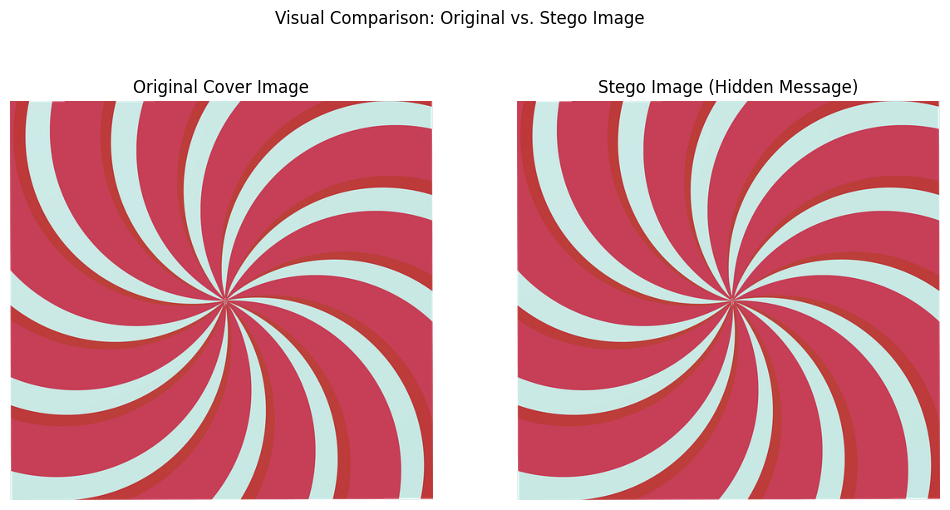


--- Receiver's Side (Image): Extracting and Decrypting ---
AES key loaded from c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\keys\aes_key_image.bin. Salt loaded from c:\Users\vedan\Desktop\hack\PYdroid--Hack--project\keys\aes_salt_image.bin.

--- Retrieved Message from Image ---
this is secret msg

Does the retrieved message match the original? True

Scenario 1 (Image) completed.
Exiting Steganography System Test. Goodbye!


In [31]:
if __name__ == "__main__":
    # Determine the base path of your project for local execution

    try:
        # This is ideal when running the script directly (e.g., python steganography_system.py)
        # It gets the directory where the script file is located.
        project_base = Path(__file__).parent
    except NameError:
        # This is used when __file__ is not defined (e.g., in Jupyter/Colab or interactive shells)
        # It gets the current working directory where the Python interpreter was started.
        # CRITICAL: Ensure you run your notebook/script *from* the 'hack' folder or navigate there first.
        project_base = Path.cwd() 
        print(f"Warning: '__file__' not defined. Using current working directory as project base: {project_base}")
        print("Please ensure you are running this script/notebook from your 'PYdroid--Hack--project' root folder.")

    # Define paths for your image dataset, audio dataset, video dataset, output folders, and keys folder
    image_dataset_path = project_base / "Images"
    audio_dataset_path = project_base / "Audio"
    # --- NEW ADDITION FOR VIDEO STEGANOGRAPHY ---
    video_dataset_path = project_base / "Videos" # Create a 'Videos' folder
    output_stego_images_path = project_base / "output_stego_images"
    output_stego_audio_path = project_base / "output_stego_audio"
    # --- NEW ADDITION FOR VIDEO STEGANOGRAPHY ---
    output_stego_videos_path = project_base / "output_stego_videos" # New output folder for videos
    keys_path = project_base / "keys"

    # Ensure all necessary directories exist
    output_stego_images_path.mkdir(exist_ok=True, parents=True)
    output_stego_audio_path.mkdir(exist_ok=True, parents=True)
    # --- NEW ADDITION FOR VIDEO STEGANOGRAPHY ---
    output_stego_videos_path.mkdir(exist_ok=True, parents=True)
    keys_path.mkdir(exist_ok=True, parents=True)
    image_dataset_path.mkdir(exist_ok=True, parents=True)
    audio_dataset_path.mkdir(exist_ok=True, parents=True)
    # --- NEW ADDITION FOR VIDEO STEGANOGRAPHY ---
    video_dataset_path.mkdir(exist_ok=True, parents=True)


    print("\n--- Directory Setup Verification ---")
    print(f"Image Dataset Path: {image_dataset_path} (exists: {image_dataset_path.exists()})")
    print(f"Audio Dataset Path: {audio_dataset_path} (exists: {audio_dataset_path.exists()})")
    print(f"Video Dataset Path: {video_dataset_path} (exists: {video_dataset_path.exists()})") # Video verification
    print(f"Output Stego Images Path: {output_stego_images_path} (exists: {output_stego_images_path.exists()})")
    print(f"Output Stego Audio Path: {output_stego_audio_path} (exists: {output_stego_audio_path.exists()})")
    print(f"Output Stego Videos Path: {output_stego_videos_path} (exists: {output_stego_videos_path.exists()})") # Video verification
    print(f"Keys Path: {keys_path} (exists: {keys_path.exists()})")
    print("------------------------------------\n")


    print("\n" + "="*50)
    print("Welcome to the Steganography System Test Scenarios!")
    print("="*50)

    while True:
        choice = input("\nChoose a scenario:\n1. Image Steganography\n2. Audio Steganography\n3. Video Steganography\n4. Exit\nEnter your choice (1, 2, 3, or 4): ")

        if choice == '1':
            # --- Scenario 1: Image Steganography ---
            print("\n" + "#"*50)
            print("Scenario 1: Image Hiding (AES-256 GCM + LSB)")
            print("#"*50)

            secret_text = input("Enter the secret message you want to hide in an image: ")
            if not secret_text:
                print("No message entered. Skipping image scenario.")
                continue
            else:
                secret_message_bytes = secret_text.encode('utf-8')
                print(f"Secret message received: '{secret_text}' (Length: {len(secret_text)} characters, {len(secret_message_bytes)} bytes)")

                available_images = [f for f in image_dataset_path.iterdir() if f.is_file()]
                
                if not available_images:
                    print(f"Error: No image files found in '{image_dataset_path}'. Cannot proceed with image steganography.")
                else:
                    cover_image_1 = random.choice(available_images)
                    stego_image_1 = output_stego_images_path / f"stego_{cover_image_1.name}"
                    print(f"Randomly selected cover image: '{cover_image_1.name}' from '{image_dataset_path}'")
                    print(f"Stego image will be saved as: '{stego_image_1}'")

                    print("\n--- Sender's Side (Image): Encrypting and Embedding ---")
                    aes_password_1 = input("Enter an AES password for image encryption (e.g., MyStrongPass): ")
                    if not aes_password_1:
                        print("No password entered. Cannot proceed with encryption.")
                    else:
                        sender_stego_sys = StegoSystem()
                        aes_key_file_img = keys_path / "aes_key_image.bin"
                        aes_salt_file_img = keys_path / "aes_salt_image.bin"

                        sender_stego_sys.generate_and_save_aes_key(aes_password_1, key_file=str(aes_key_file_img), salt_file=str(aes_salt_file_img))

                        if sender_stego_sys.encrypt_and_hide(secret_message_bytes, str(cover_image_1), str(stego_image_1)):
                            print(f"\nSecret message successfully hidden in '{stego_image_1}'.")
                            print("\nVisualizing Original vs. Stego Image (look closely!):")
                            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                            original_img = Image.open(cover_image_1)
                            stego_img = Image.open(stego_image_1)
                            axes[0].imshow(original_img)
                            axes[0].set_title("Original Cover Image")
                            axes[0].axis('off')
                            axes[1].imshow(stego_img)
                            axes[1].set_title("Stego Image (Hidden Message)")
                            axes[1].axis('off')
                            plt.suptitle("Visual Comparison: Original vs. Stego Image")
                            plt.show()
                        else:
                            print("\nFailed to encrypt and hide the message in image.")

                        print("\n--- Receiver's Side (Image): Extracting and Decrypting ---")
                        receiver_password_1 = input("Enter the AES password to decrypt the image message: ")

                        receiver_stego_sys = StegoSystem()
                        receiver_stego_sys.load_aes_key(receiver_password_1, key_file=str(aes_key_file_img), salt_file=str(aes_salt_file_img))

                        retrieved_text_bytes = receiver_stego_sys.extract_and_decrypt(str(stego_image_1))
                        if retrieved_text_bytes:
                            retrieved_text = retrieved_text_bytes.decode('utf-8')
                            print("\n--- Retrieved Message from Image ---")
                            print(retrieved_text)
                            print(f"\nDoes the retrieved message match the original? {retrieved_text == secret_text}")
                        else:
                            print("\nFailed to retrieve or decrypt message from image.")
            print("\nScenario 1 (Image) completed.")

        elif choice == '2':
            # --- Scenario 2: Audio Steganography ---
            print("\n" + "#"*50)
            print("Scenario 2: Audio Hiding (AES-256 GCM + WAV LSB)")
            print("#"*50)

            audio_secret_text = input("Enter the secret message you want to hide in audio: ")
            if not audio_secret_text:
                print("No audio message entered. Skipping audio scenario.")
                continue
            else:
                audio_secret_message_bytes = audio_secret_text.encode('utf-8')
                print(f"Audio secret message received: '{audio_secret_text}' (Length: {len(audio_secret_text)} characters, {len(audio_secret_message_bytes)} bytes)")

                available_audio_files = [f for f in audio_dataset_path.iterdir() if f.is_file() and f.suffix.lower() == '.wav']
                
                if not available_audio_files:
                    print(f"CRITICAL ERROR: No suitable WAV audio files found in '{audio_dataset_path}'.")
                    print("Please ensure your 'Audio' folder exists and contains .wav files.")
                    print("Cannot proceed with audio-based steganography.")
                    # Optional: Offer to convert MP3 to WAV here using pydub if desired
                    # For now, it just informs the user.
                else:
                    cover_audio_1 = random.choice(available_audio_files)
                    stego_audio_1 = output_stego_audio_path / f"stego_{cover_audio_1.name}"
                    print(f"Randomly selected cover audio: '{cover_audio_1.name}' from '{audio_dataset_path}'")
                    print(f"Stego audio will be saved as: '{stego_audio_1.name}'")

                    print("\n--- Sender's Side (Audio): Encrypting and Embedding ---")
                    audio_aes_password_1 = input("Enter an AES password for audio encryption: ")
                    if not audio_aes_password_1:
                        print("No password entered for audio. Cannot proceed with encryption.")
                    else:
                        audio_sender_stego_sys = StegoSystem()
                        audio_aes_key_file = keys_path / "aes_key_audio.bin"
                        audio_aes_salt_file = keys_path / "aes_salt_audio.bin"

                        audio_sender_stego_sys.generate_and_save_aes_key(audio_aes_password_1, key_file=str(audio_aes_key_file), salt_file=str(audio_aes_salt_file))

                        if audio_sender_stego_sys.encrypt_and_hide_audio(audio_secret_message_bytes, str(cover_audio_1), str(stego_audio_1)):
                            print(f"\nSecret message successfully hidden in '{stego_audio_1}'.")
                            print("\n--- Audio Playback (requires IPython.display.Audio in Colab/Jupyter) ---")
                            if IPYTHON_AUDIO_AVAILABLE:
                                try:
                                    print(f"Original Audio ({cover_audio_1.name}):")
                                    display(Audio(cover_audio_1))
                                    print(f"Stego Audio ({stego_audio_1.name}):")
                                    display(Audio(stego_audio_1))
                                    print("Listen closely for any audible differences. Slight noise may be introduced by LSB.")
                                except Exception as e:
                                    print(f"Error playing audio: {e}")
                            else:
                                print("IPython.display.Audio not available. Cannot play audio in this environment.")
                        else:
                            print("\nFailed to encrypt and hide the message in audio.")

                    print("\n--- Receiver's Side (Audio): Extracting and Decrypting ---")
                    audio_receiver_password_1 = input("Enter the AES password for audio decryption: ")

                    audio_receiver_stego_sys = StegoSystem()
                    audio_receiver_stego_sys.load_aes_key(audio_receiver_password_1, key_file=str(audio_aes_key_file), salt_file=str(audio_aes_salt_file))

                    retrieved_audio_text_bytes = audio_receiver_stego_sys.extract_and_decrypt_audio(str(stego_audio_1))
                    if retrieved_audio_text_bytes:
                        retrieved_audio_text = retrieved_audio_text_bytes.decode('utf-8')
                        print("\n--- Retrieved Audio Message ---")
                        print(retrieved_audio_text)
                        print(f"\nDoes the retrieved audio message match the original? {retrieved_audio_text == audio_secret_text}")
                    else:
                        print("\nFailed to retrieve or decrypt audio message.")
            print("\nScenario 2 (Audio) completed.")
        
        # --- NEW ADDITION FOR VIDEO STEGANOGRAPHY SCENARIO ---
        elif choice == '3':
            # --- Scenario 3: Video Steganography ---
            print("\n" + "#"*50)
            print("Scenario 3: Video Hiding (AES-256 GCM + LSB Frame by Frame)")
            print("#"*50)

            video_secret_text = input("Enter the secret message you want to hide in a video: ")
            if not video_secret_text:
                print("No video message entered. Skipping video scenario.")
                continue
            else:
                video_secret_message_bytes = video_secret_text.encode('utf-8')
                print(f"Video secret message received: '{video_secret_text}' (Length: {len(video_secret_text)} characters, {len(video_secret_message_bytes)} bytes)")

                # Common video formats that OpenCV can usually read
                supported_video_extensions = ['.mp4', '.avi', '.mov', '.mkv'] 
                available_video_files = [f for f in video_dataset_path.iterdir() if f.is_file() and f.suffix.lower() in supported_video_extensions]
                
                if not available_video_files:
                    print(f"CRITICAL ERROR: No suitable video files found in '{video_dataset_path}'.")
                    print(f"Please ensure your 'Videos' folder exists and contains video files ({', '.join(supported_video_extensions)}).")
                    print("Cannot proceed with video-based steganography.")
                else:
                    cover_video_1 = random.choice(available_video_files)
                    # Use a .mp4 extension for output as it's widely compatible
                    stego_video_1 = output_stego_videos_path / f"stego_{cover_video_1.stem}.mp4" 
                    print(f"Randomly selected cover video: '{cover_video_1.name}' from '{video_dataset_path}'")
                    print(f"Stego video will be saved as: '{stego_video_1.name}'")

                    print("\n--- Sender's Side (Video): Encrypting and Embedding ---")
                    video_aes_password_1 = input("Enter an AES password for video encryption: ")
                    if not video_aes_password_1:
                        print("No password entered for video. Cannot proceed with encryption.")
                    else:
                        video_sender_stego_sys = StegoSystem()
                        video_aes_key_file = keys_path / "aes_key_video.bin"
                        video_aes_salt_file = keys_path / "aes_salt_video.bin"

                        video_sender_stego_sys.generate_and_save_aes_key(video_aes_password_1, key_file=str(video_aes_key_file), salt_file=str(video_aes_salt_file))

                        if video_sender_stego_sys.encrypt_and_hide_video(video_secret_message_bytes, str(cover_video_1), str(stego_video_1)):
                            print(f"\nSecret message successfully hidden in '{stego_video_1}'.")
                            print("\nNote: Video visualization not implemented here as it's complex for CLI. "
                                  "You can play the stego video file separately to inspect it.")
                        else:
                            print("\nFailed to encrypt and hide the message in video.")

                    print("\n--- Receiver's Side (Video): Extracting and Decrypting ---")
                    video_receiver_password_1 = input("Enter the AES password for video decryption: ")

                    video_receiver_stego_sys = StegoSystem()
                    video_receiver_stego_sys.load_aes_key(video_receiver_password_1, key_file=str(video_aes_key_file), salt_file=str(video_aes_salt_file))

                    retrieved_video_text_bytes = video_receiver_stego_sys.extract_and_decrypt_video(str(stego_video_1))
                    if retrieved_video_text_bytes:
                        retrieved_video_text = retrieved_video_text_bytes.decode('utf-8')
                        print("\n--- Retrieved Video Message ---")
                        print(retrieved_video_text)
                        print(f"\nDoes the retrieved video message match the original? {retrieved_video_text == video_secret_text}")
                    else:
                        print("\nFailed to retrieve or decrypt video message.")
            print("\nScenario 3 (Video) completed.")

        elif choice == '4': # Updated exit choice
            print("Exiting Steganography System Test. Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1, 2, 3, or 4.")